# Install ORTEGA

In [25]:
!pip install ortega

In [1]:
import pandas as pd
import ortega

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type and the value must contains year, month, day, hour, minute, and second. 

In [2]:
bigdata = pd.read_csv('/path/Mother_Cub1.csv', sep=',',header=0)
bigdata['Time_LMT'] = pd.to_datetime(bigdata.Time_LMT)
print('total number of gps points:', bigdata.shape[0])

total number of gps points: 10414


# Convert longitude latitude to epsg:3857
If tracking data are already in projected coordinate system, users can skip this step. Otherwise, longitude and latitude coordinates need to be converted to projected coordinate system coordinates. We recommend using the epsg:3857 projected coordinate system because it is used for rendering maps in many common apps such as Google Maps, OpenStreetMap, etc.

In [20]:
!pip install pyproj fastkml shapely

In [3]:
%%time
import pyproj
from fastkml import kml
from shapely.geometry import Point
from shapely.ops import transform

p = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def convert_to_projected(x, lat, lon):
    point = Point(float(x[lon]), float(x[lat]))
    projected_point = transform(p.transform, point)
    x[lat], x[lon] = projected_point.y, projected_point.x
    return x

bigdata = bigdata.apply(lambda x: convert_to_projected(x, 'latitude', 'longitude'), axis=1)

CPU times: user 1.92 s, sys: 80.5 ms, total: 2 s
Wall time: 2.03 s


# Initializing ORTEGA object
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify the field names based on the data they used.

In [4]:
interaction1 = ortega.ORTEGA(data=bigdata,
                             start_time='2020-01-01 00:00:00',  ##set a time window to subset data
                             end_time='2020-01-10 00:00:00',
                             minute_delay=60,
                             time_field='Time_LMT',
                             id_field='idcollar',
                             )

2023-03-15 12:02:21.793879 Initializing ORTEGA object...
2023-03-15 12:02:21.802102 Generate PPA list for the two moving entities...
2023-03-15 12:02:21.934150 Generating PPA list completed!
2023-03-15 12:02:21.934348 Initialization success!


# Implement interaction analysis

The below cell runs interaction_analysis() and it returns three values. 
- The first value is a list of intersecting PPA pairs as paired built-in Ellipse objects.
- The second return value is a dataframe containing all intersecting PPA pairs. 
- The third return value is a dataframe that includes all identified continuous interaction segments (interaction events).

In [5]:
intersecting_ellipse_list, df_intersecting_PPAs, df_duration = interaction1.interaction_analysis()

2023-03-15 12:02:23.036307 Implement interaction analysis...
2023-03-15 12:02:23.036376 Getting spatial and temporal intersection pairs...
2023-03-15 12:02:23.321503 Getting spatial and temporal intersection pairs completed!
2023-03-15 12:02:23.321651 Complete! 169 pairs of intersecting PPAs found!
2023-03-15 12:02:23.326384 Compute duration of interaction...
2023-03-15 12:02:23.338643 Complete! 13 interaction events identified!


The beblow results indicate 10 interaction events between these two moving entities.
The dataframe df_duration includes six columns: 
- No: event no. sorted by start time
- P1: unique id for individual 1
- P2: unique id for individual 2
- Start: start time of the interaction
- End: end time of the interaction
- Duration: duration of the interaction event (in minutes)

In [6]:
df_duration

,No,P1,P2,Start,End,Duration
0,1,131343,229012,2020-01-01 13:00:00,2020-01-01 22:00:00,540.0
1,2,131343,229012,2020-01-02 00:00:00,2020-01-02 08:00:00,480.0
2,3,131343,229012,2020-01-02 15:00:00,2020-01-03 09:00:00,1080.0
3,4,131343,229012,2020-01-03 12:00:00,2020-01-03 16:00:00,240.0
4,5,131343,229012,2020-01-03 18:00:00,2020-01-04 02:00:00,480.0
5,6,131343,229012,2020-01-04 05:00:00,2020-01-04 08:00:00,180.0
6,7,131343,229012,2020-01-04 11:00:00,2020-01-04 21:00:00,600.0
7,8,131343,229012,2020-01-06 05:00:00,2020-01-06 13:00:00,480.0
8,9,131343,229012,2020-01-06 16:00:00,2020-01-06 21:00:00,300.0
9,10,131343,229012,2020-01-07 18:00:00,2020-01-07 22:00:00,240.0


# Compute PPA size and use violin plots to show the distribution

In [7]:
ppasize_list = interaction1.compute_ppa_size()

Descriptive statistics of PPA ellipses length for id 131343:
count      211.000000
mean      1034.163221
std       1736.831164
min          1.473494
25%         49.046156
50%        135.202816
75%       1205.931528
max      10706.359135
dtype: float64
Descriptive statistics of PPA ellipses length for id 229012:
count     208.000000
mean      395.968431
std       852.819043
min         1.978216
25%        34.342929
50%        71.930112
75%       262.903868
max      8374.730500
dtype: float64


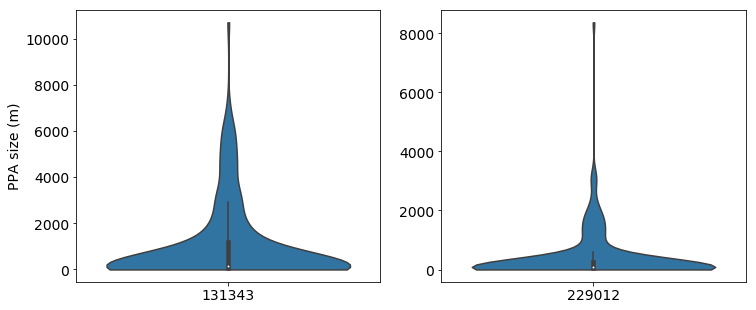

In [9]:
import seaborn
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppasize_list[0], ax=ax1,cut=0)
seaborn.violinplot(data=ppasize_list[1], ax=ax2,cut=0)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA size (m)')
# ax2.set_ylabel('PPA size (m)')
plt.show()

# Compute PPA speed and use violin plots to show the distribution

In [10]:
ppaspeed_list = interaction1.compute_ppa_speed()

Descriptive statistics of PPA ellipses length for id 131343:
count    211.000000
mean       0.105678
std        0.169915
min        0.000160
25%        0.005261
50%        0.014474
75%        0.131248
max        0.818413
dtype: float64
Descriptive statistics of PPA ellipses length for id 229012:
count    208.000000
mean       0.039584
std        0.072990
min        0.000215
25%        0.003721
50%        0.007452
75%        0.028613
max        0.448262
dtype: float64


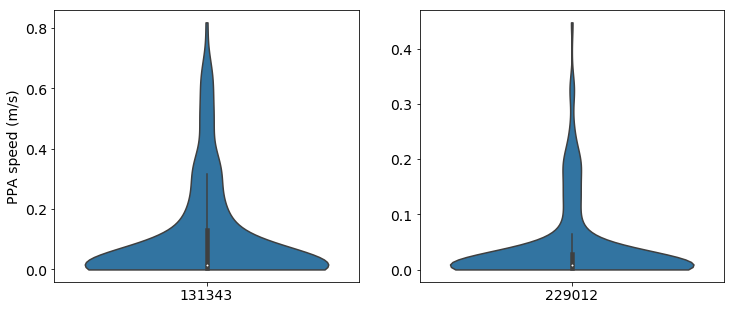

In [11]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppaspeed_list[0], ax=ax1,cut=0)
seaborn.violinplot(data=ppaspeed_list[1], ax=ax2,cut=0)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA speed (m/s)')
# ax2.set_ylabel('PPA speed (m/s)')
plt.show()

# Compute PPA interval and use violin plot to show the distribution

In [12]:
interval_list = interaction1.compute_ppa_interval()

Descriptive statistics of PPA ellipses time interval (minutes) for id 131343:
count    211.000000
mean      61.421801
std        9.237981
min       57.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      122.000000
Name: Time_LMT, dtype: float64
Descriptive statistics of PPA ellipses time interval (minutes) for id 229012:
count    208.000000
mean      62.307692
std       18.547538
min       57.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      300.000000
Name: Time_LMT, dtype: float64


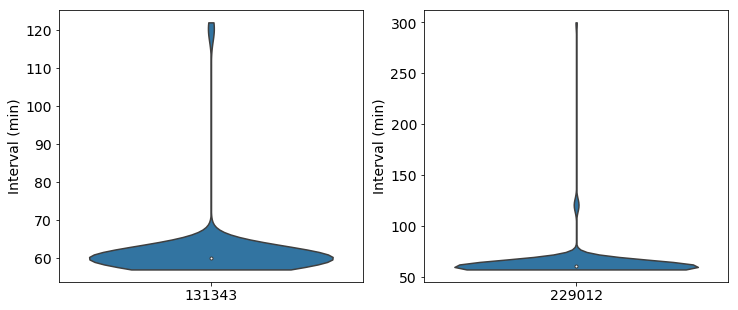

In [14]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=interval_list[0].tolist(), ax=ax1,cut=0)
seaborn.violinplot(data=interval_list[1].tolist(), ax=ax2,cut=0)
ax1.set_xticklabels([interaction1.id1])
ax2.set_xticklabels([interaction1.id2])
ax1.set_ylabel('Interval (min)')
ax2.set_ylabel('Interval (min)')
plt.show()

# Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

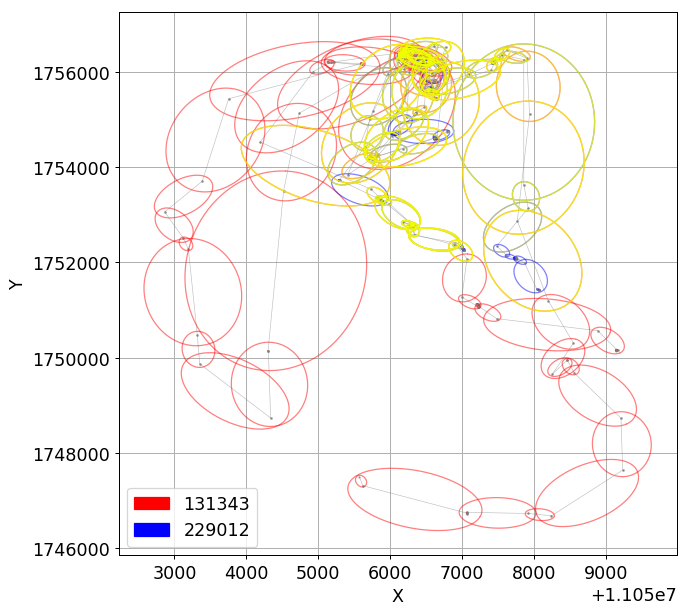

In [15]:
ortega.visualization.plot_interaction(interaction1, intersecting_ellipse_list)

map the original tracks without annotating intersecting portion

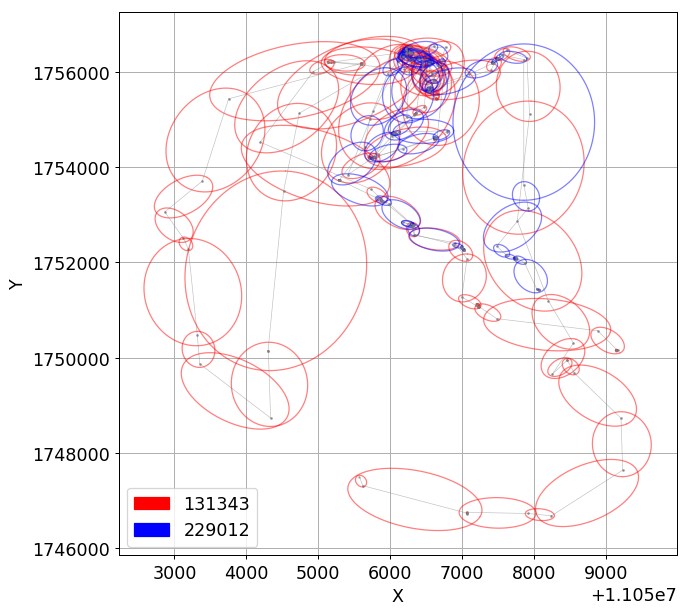

In [16]:
ortega.visualization.plot_original_tracks(interaction1) 

# Explore the difference in speed and movement  direction when individuals interact

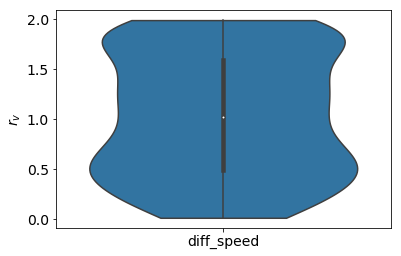

In [18]:
plt.rcParams.update({'font.size': 14})
ax = seaborn.violinplot(data=df_intersecting_PPAs['diff_speed'],cut=0)
ax.set_xticklabels(['diff_speed'])
ax.set_ylabel(r'$r_v$')
plt.show()

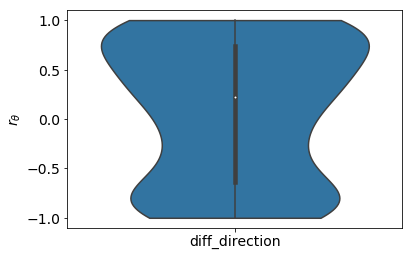

In [19]:
plt.rcParams.update({'font.size': 14})
ax = seaborn.violinplot(data=df_intersecting_PPAs['diff_direction'],cut=0)
ax.set_xticklabels(['diff_direction'])
ax.set_ylabel(r'$r_\theta$')
plt.show()